# **Assignment 1, Problem 1**
### *Carlos Ramon Escandell*
#### 09/30/2024
##### carlos.ramonescandell@mail.utoronto.ca

### Exercise 1

In [51]:
import numpy as np
import mpmath
from scipy.optimize import root_scalar

# Set the decimal precision in mpmath (library that we use for computing the zeta and polylog functions)
mpmath.mp.dps = 25 

# Define the potentials and their corresponding alpha values
potentials = {
    '3D Box (α=1.5)': 1.5,
    '2D Harmonic Oscillator (α=2)': 2.0,
    '3D Harmonic Oscillator (α=3)': 3.0
}

# Create an array of T/Tc values from 0 to 2
T_over_Tc = np.linspace(0, 2, 500)

# Initialize a dictionary to store the data for each potential
data = {}

# Loop over the potentials and alpha values
for label, alpha in potentials.items():
    # Initialize arrays to hold μ/(k_B T_c) and z values
    mu_over_kTc = np.zeros_like(T_over_Tc)
    z_values = np.zeros_like(T_over_Tc)
    
    # For T/Tc ≤ 1, μ = 0 and z = 1 (since μ = 0 ⇒ z = 1)
    mu_over_kTc[T_over_Tc <= 1] = 0
    z_values[T_over_Tc <= 1] = 1.0

    # Precompute zeta function value
    zeta_alpha = float(mpmath.zeta(alpha))
    
    # Define the function to compute μ for alpha ≠ 1
    def compute_mu_z(T_Tc):
        # Compute RHS of the equation
        RHS = T_Tc ** (-alpha) * zeta_alpha
        
        # Define the function f(logz)
        def f(logz):
            z = np.exp(logz)
            if z >= 1.0 or z <= 0.0:
                return np.inf  # Return a large number to avoid invalid z
            polylog_value = float(mpmath.polylog(alpha, z))
            return polylog_value - RHS
        
        # Since z ∈ (0,1), log(z) ∈ (−∞,0)
        logz_min = -50
        logz_max = -1e-12
        
        # Check if f(logz_min) and f(logz_max) have opposite signs
        f_min = f(logz_min)
        f_max = f(logz_max)
        if np.sign(f_min) == np.sign(f_max):
            # If not, return NaN
            return np.nan, np.nan
        sol = root_scalar(f, method='bisect', bracket=[logz_min, logz_max], xtol=1e-12)
        if sol.converged:
            logz = sol.root
            z = np.exp(logz)
            mu_over_kTc = T_Tc * logz
            return mu_over_kTc, z
        else:
            return np.nan, np.nan

    # Compute μ/(k_B T_c) and z for T/Tc > 1
    for i, T_Tc in enumerate(T_over_Tc):
        if T_Tc > 1:
            mu_kTc, z = compute_mu_z(T_Tc)
            mu_over_kTc[i] = mu_kTc
            z_values[i] = z
        else:
            mu_over_kTc[i] = 0
            z_values[i] = 1.0  # Since μ = 0 ⇒ z = 1

    # Store the data in the dictionary
    data[label] = {
        'T_over_Tc': T_over_Tc,
        'mu_over_kTc': mu_over_kTc,
        'z': z_values
    }

    # Save the data to a CSV file
    filename = f"mu_z_data_alpha_{alpha}.csv"
    np.savetxt(
        filename,
        np.column_stack((T_over_Tc, mu_over_kTc, z_values)),
        delimiter=",",
        header="T_over_Tc, mu_over_kTc, z",
        comments=""
    )
    print(f"Data for {label} saved to {filename}")


Data for 3D Box (α=1.5) saved to mu_z_data_alpha_1.5.csv
Data for 2D Harmonic Oscillator (α=2) saved to mu_z_data_alpha_2.0.csv
Data for 3D Harmonic Oscillator (α=3) saved to mu_z_data_alpha_3.0.csv


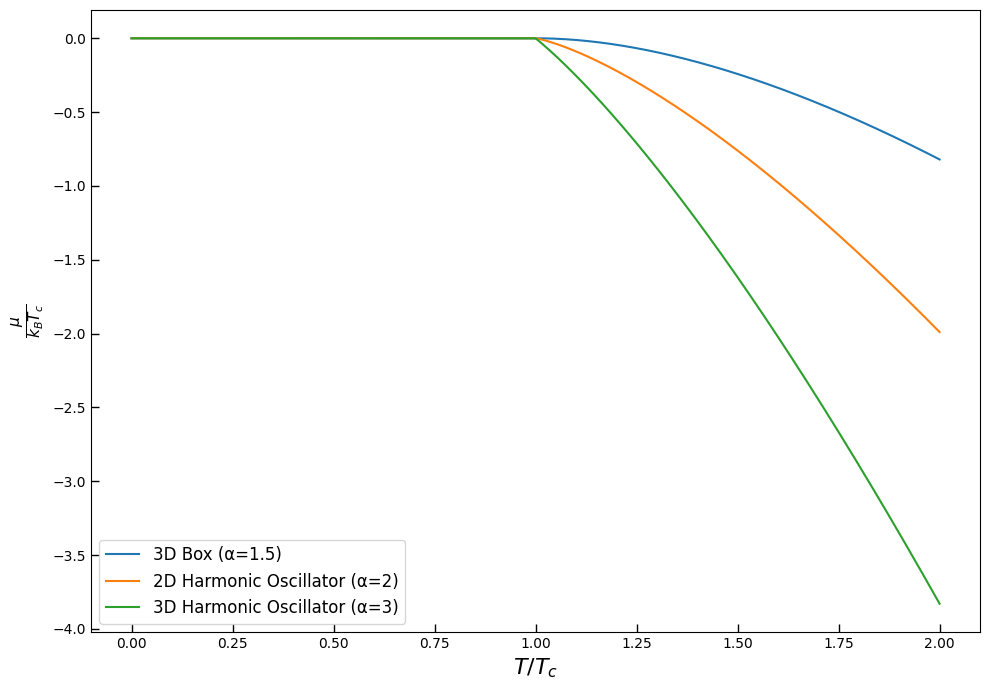

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# List of alpha values corresponding to the potentials
alpha_values = [1.5, 2.0, 3.0]
labels = ['3D Box (α=1.5)', '2D Harmonic Oscillator (α=2)', '3D Harmonic Oscillator (α=3)']

# Initialize a dictionary to store the loaded data
loaded_data = {}

# Read data from CSV files
for alpha, label in zip(alpha_values, labels):
    filename = f"mu_z_data_alpha_{alpha}.csv"
    data_array = np.loadtxt(filename, delimiter=",", skiprows=1)
    T_over_Tc_loaded = data_array[:, 0]
    mu_over_kTc_loaded = data_array[:, 1]
    z_loaded = data_array[:, 2]
    loaded_data[label] = {
        'T_over_Tc': T_over_Tc_loaded,
        'mu_over_kTc': mu_over_kTc_loaded,
        'z': z_loaded
    }

# Plotting the data
plt.figure(figsize=(10, 7))
for label in labels:
    T_over_Tc = loaded_data[label]['T_over_Tc']
    mu_over_kTc = loaded_data[label]['mu_over_kTc']
    plt.plot(T_over_Tc, mu_over_kTc, label=label)

# Setting labels and legend
plt.xlabel(r'$T/T_c$', fontsize=16)
plt.ylabel(r'$\frac{\mu}{k_B T_c}$', fontsize=16)
plt.legend(fontsize=12)

# Add ticks inside the plot
plt.tick_params(axis='both', direction='in', length=6, width=1)

# Layout and saving the plot
plt.tight_layout()
plt.savefig('question1')
plt.show()


### Exercise 2

In [55]:
import numpy as np
import mpmath
from scipy.special import zeta
from scipy.optimize import root_scalar

# Set the decimal precision in mpmath
mpmath.mp.dps = 25 

# Define the potentials and their corresponding α values
potentials = {
    '3D Box (α=1.5)': 1.5,
    '2D Harmonic Oscillator (α=2)': 2.0,
    '3D Harmonic Oscillator (α=3)': 3.0
}

# Total number of particles
N = 100  # As per the problem statement

# Create an array of T/Tc values from 0.01 to 0.99 (below Tc)
T_over_Tc = np.linspace(0.01, 0.99, 500)  # Avoid T/Tc = 0 to prevent division by zero

# Initialize a dictionary to store the data for each potential
data = {}

# Loop over the potentials and alpha values
for label, alpha in potentials.items():
    # Initialize arrays to hold μ/(k_B T_c) values and z
    mu_over_kTc = np.zeros_like(T_over_Tc)
    z_values = np.zeros_like(T_over_Tc)
    
    # Compute the condensate number n0 for each T/Tc
    n0 = N * (1 - T_over_Tc**alpha)
    
    # Ensure n0 is non-negative (avoid numerical errors)
    n0 = np.maximum(n0, 0)
    
    # Compute z using n0
    z = n0 / (n0 + 1)
    
    # Handle cases where n0 = 0 to avoid division by zero
    z[n0 == 0] = 0  # When n0 = 0, z = 0
    
    # Compute mu / (k_B T_c)
    mu_over_kTc = T_over_Tc * np.log(z)
    
    # Handle cases where z = 0 (mu diverges to -infinity)
    mu_over_kTc[z == 0] = -np.inf
    
    # Store the data in the dictionary
    data[label] = {
        'T_over_Tc': T_over_Tc,
        'mu_over_kTc': mu_over_kTc,
        'z': z
    }
    
    # Save the data to a CSV file
    filename = f"exercise2_mu_z_data_alpha_{alpha}.csv"
    np.savetxt(
        filename,
        np.column_stack((T_over_Tc, mu_over_kTc, z)),
        delimiter=",",
        header="T_over_Tc, mu_over_kTc, z",
        comments=""
    )
    print(f"Data for {label} saved to {filename}")


Data for 3D Box (α=1.5) saved to exercise2_mu_z_data_alpha_1.5.csv
Data for 2D Harmonic Oscillator (α=2) saved to exercise2_mu_z_data_alpha_2.0.csv
Data for 3D Harmonic Oscillator (α=3) saved to exercise2_mu_z_data_alpha_3.0.csv


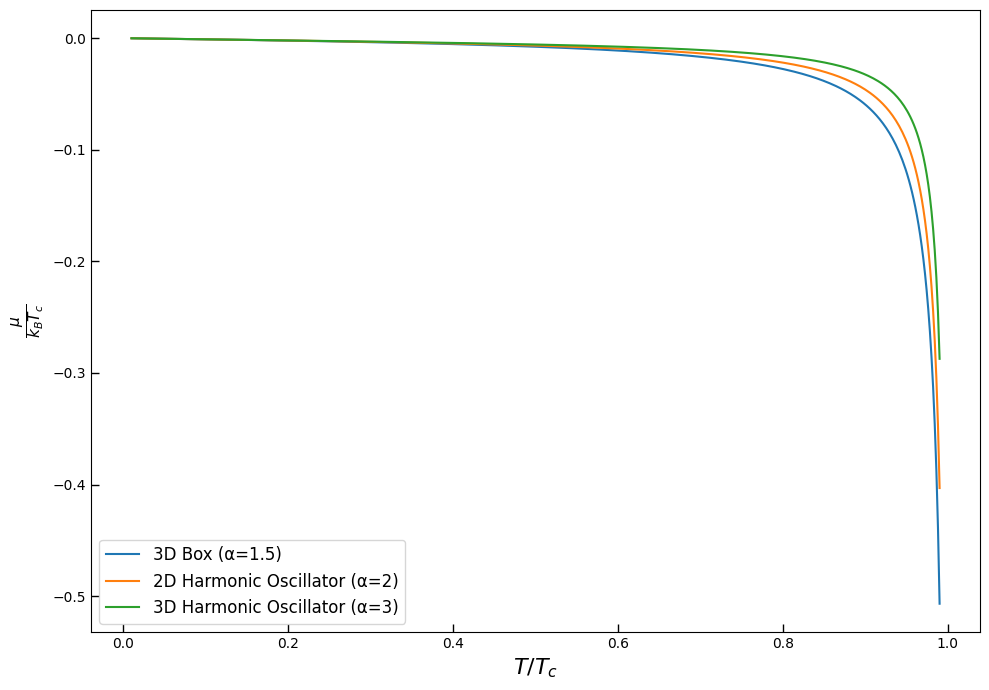

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# List of alpha values and labels corresponding to the potentials
alpha_values = [1.5, 2.0, 3.0]
labels = ['3D Box (α=1.5)', '2D Harmonic Oscillator (α=2)', '3D Harmonic Oscillator (α=3)']

# Initialize a dictionary to store the loaded data
loaded_data = {}

# Read data from CSV files
for alpha, label in zip(alpha_values, labels):
    filename = f"exercise2_mu_z_data_alpha_{alpha}.csv"
    data_array = np.loadtxt(filename, delimiter=",", skiprows=1)
    T_over_Tc_loaded = data_array[:, 0]
    mu_over_kTc_loaded = data_array[:, 1]
    z_loaded = data_array[:, 2]
    loaded_data[label] = {
        'T_over_Tc': T_over_Tc_loaded,
        'mu_over_kTc': mu_over_kTc_loaded,
        'z': z_loaded
    }

# Plotting the data
plt.figure(figsize=(10, 7))
for label in labels:
    T_over_Tc = loaded_data[label]['T_over_Tc']
    mu_over_kTc = loaded_data[label]['mu_over_kTc']
    plt.plot(T_over_Tc, mu_over_kTc, label=label)

plt.xlabel(r'$T/T_c$', fontsize=16)
plt.ylabel(r'$\frac{\mu}{k_B T_c}$', fontsize=16)
plt.tick_params(axis='both', direction='in', length=6, width=1)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('question2.png')
plt.show()

### Exercise 3

In [9]:
import numpy as np
import mpmath
from scipy.special import zeta
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Set high precision for mpmath
mpmath.mp.dps = 25

# Potentials and their α values
potentials = {
    '3D Box (α=1.5)': 1.5,
    '2D Harmonic Oscillator (α=2)': 2.0,
    '3D Harmonic Oscillator (α=3)': 3.0
}

# Total number of particles
N = 100

# Temperature range below T_c
T_over_Tc = np.linspace(0.01, 0.99, 500)


In [10]:
# List of alpha values and labels corresponding to the potentials
alpha_values = [1.5, 2.0, 3.0]
labels = ['3D Box (α=1.5)', '2D Harmonic Oscillator (α=2)', '3D Harmonic Oscillator (α=3)']

# Initialize a dictionary to store the loaded data for Solution (ii)
data_ex2 = {}

# Read data from Exercise 2 CSV files
for alpha, label in zip(alpha_values, labels):
    filename = f"exercise2_mu_z_data_alpha_{alpha}.csv"
    data_array = np.loadtxt(filename, delimiter=",", skiprows=1)
    T_over_Tc_loaded = data_array[:, 0]
    mu_over_kTc_loaded = data_array[:, 1]
    z_loaded = data_array[:, 2]
    data_ex2[label] = {
        'T_over_Tc': T_over_Tc_loaded,
        'mu_over_kTc': mu_over_kTc_loaded,
        'z': z_loaded
    }


In [11]:
# Prepare μ/(k_B T_c) = 0 for Solution (i)
data_ex1 = {}
for label in labels:
    mu_over_kTc_zero = np.zeros_like(T_over_Tc)
    data_ex1[label] = {
        'T_over_Tc': T_over_Tc,
        'mu_over_kTc': mu_over_kTc_zero
    }


In [12]:
# Initialize a dictionary to store μ/(k_B T_c) for the self-consistent solution
mu_over_kTc_self_consistent = {}

# Loop over the potentials and α values
for alpha, label in zip(alpha_values, labels):
    mu_over_kTc = np.zeros_like(T_over_Tc)
    z_solution_array = np.zeros_like(T_over_Tc)
    z_initial_array = data_ex2[label]['z']  # Initial guesses from Exercise 2
    zeta_alpha = float(mpmath.zeta(alpha))
    
    # Solve for z at each temperature
    for i, T_Tc in enumerate(T_over_Tc):
        # Initial guess for z
        z_guess = z_initial_array[i]
        if np.isnan(z_guess) or z_guess <= 0 or z_guess >= 1:
            z_guess = 0.5  # Default guess if invalid
        
        # Define the function f(z) = N - n0(z) - N_ex(z, T) = 0
        def f(z):
            if z <= 0.0 or z >= 1.0:
                return np.inf  # Return a large number outside valid range
            n0 = z / (1 - z)
            polylog_value = mpmath.polylog(alpha, z)
            if isinstance(polylog_value, mpmath.mpc):
                polylog_value = polylog_value.real  # Take real part if complex
            N_ex = N * (T_Tc) ** alpha * polylog_value / zeta_alpha
            total = N - n0 - N_ex
            return float(total)
        
        # Solve for z
        try:
            sol = root_scalar(f, method='brentq', bracket=[1e-12, 1 - 1e-12], x0=z_guess, xtol=1e-12)
            if sol.converged:
                z_sol = sol.root
                z_sol = min(max(z_sol, 1e-12), 1 - 1e-12)  # Ensure z_sol is within (0,1)
                mu_over_kTc[i] = T_Tc * np.log(z_sol)
                z_solution_array[i] = z_sol
            else:
                mu_over_kTc[i] = np.nan
                z_solution_array[i] = np.nan
        except Exception:
            mu_over_kTc[i] = np.nan
            z_solution_array[i] = np.nan
    
    # Store the data for Solution (iii)
    mu_over_kTc_self_consistent[label] = {
        'T_over_Tc': T_over_Tc,
        'mu_over_kTc': mu_over_kTc,
        'z': z_solution_array
    }
    
    # Save the data to CSV files
    filename = f"exercise3_mu_z_data_alpha_{alpha}.csv"
    np.savetxt(
        filename,
        np.column_stack((T_over_Tc, mu_over_kTc, z_solution_array)),
        delimiter=",",
        header="T_over_Tc, mu_over_kTc, z",
        comments=""
    )
    print(f"Data for {label} saved to {filename}")


Data for 3D Box (α=1.5) saved to exercise3_mu_z_data_alpha_1.5.csv
Data for 2D Harmonic Oscillator (α=2) saved to exercise3_mu_z_data_alpha_2.0.csv
Data for 3D Harmonic Oscillator (α=3) saved to exercise3_mu_z_data_alpha_3.0.csv


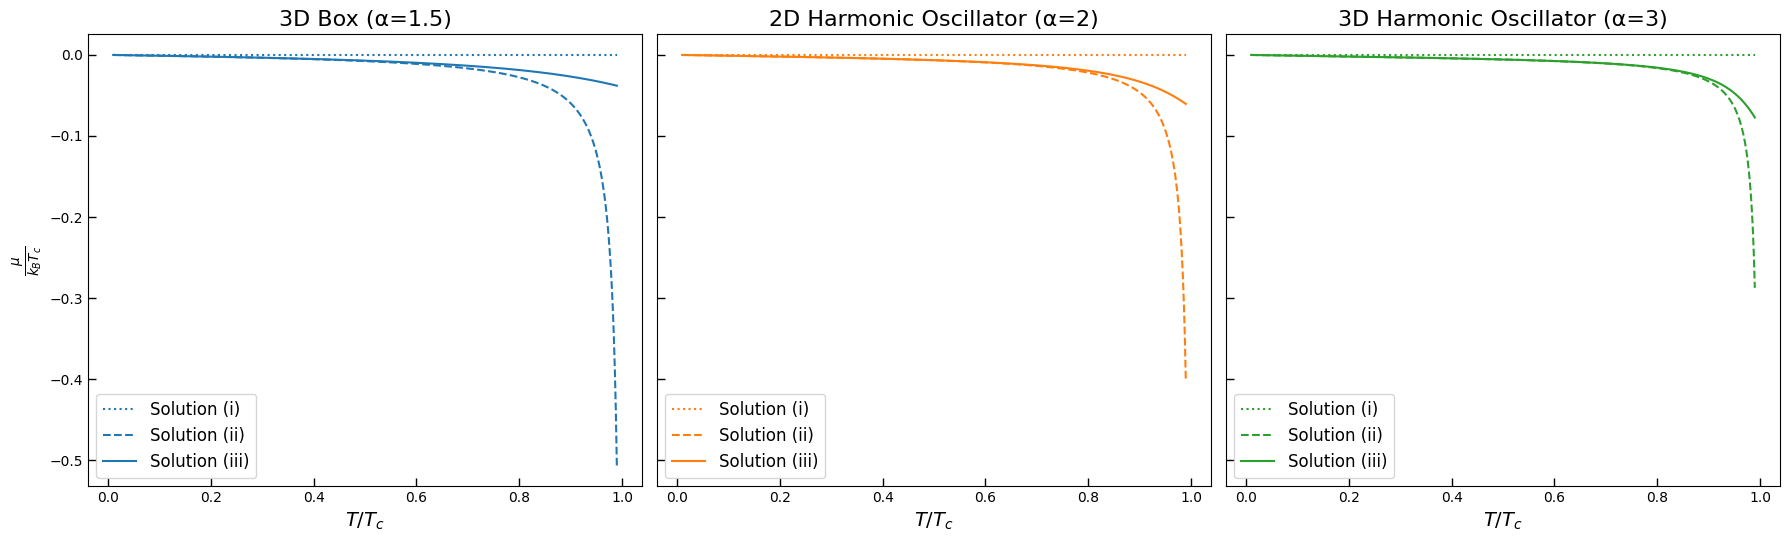

In [72]:
import matplotlib.pyplot as plt

# Default Matplotlib colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Assign each label a color based on Matplotlib's default cycle
label_colors = {
    '3D Box (α=1.5)': colors[0],   # First default color
    '2D Harmonic Oscillator (α=2)': colors[1],  # Second default color
    '3D Harmonic Oscillator (α=3)': colors[2]   # Third default color
}

for ax, alpha, label in zip(axes, alpha_values, labels):
    # Data for Solution (i)
    T_over_Tc = data_ex1[label]['T_over_Tc']
    mu_over_kTc_i = data_ex1[label]['mu_over_kTc']
    
    # Data for Solution (ii)
    mu_over_kTc_ii = data_ex2[label]['mu_over_kTc']
    
    # Data for Solution (iii)
    filename = f"exercise3_mu_z_data_alpha_{alpha}.csv"
    data_array = np.loadtxt(filename, delimiter=",", skiprows=1)
    mu_over_kTc_iii = data_array[:, 1]
    
    # Get the color assigned to the current label
    color = label_colors[label]
    
    # Plot the solutions using the same color in the current subplot
    ax.plot(T_over_Tc, mu_over_kTc_i, label='Solution (i)', linestyle='dotted', color=color)
    ax.plot(T_over_Tc, mu_over_kTc_ii, label='Solution (ii)', linestyle='--', color=color)
    ax.plot(T_over_Tc, mu_over_kTc_iii, label='Solution (iii)', linestyle='-', color=color)
    
    ax.set_title(f'{label}', fontsize=16)
    ax.set_xlabel(r'$T/T_c$', fontsize=14)
    ax.legend(fontsize=12)
    ax.tick_params(axis='both', direction='in', length=6, width=1)
    
axes[0].set_ylabel(r'$\frac{\mu}{k_B T_c}$', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('question3.png')
plt.show()


### Exercise 4

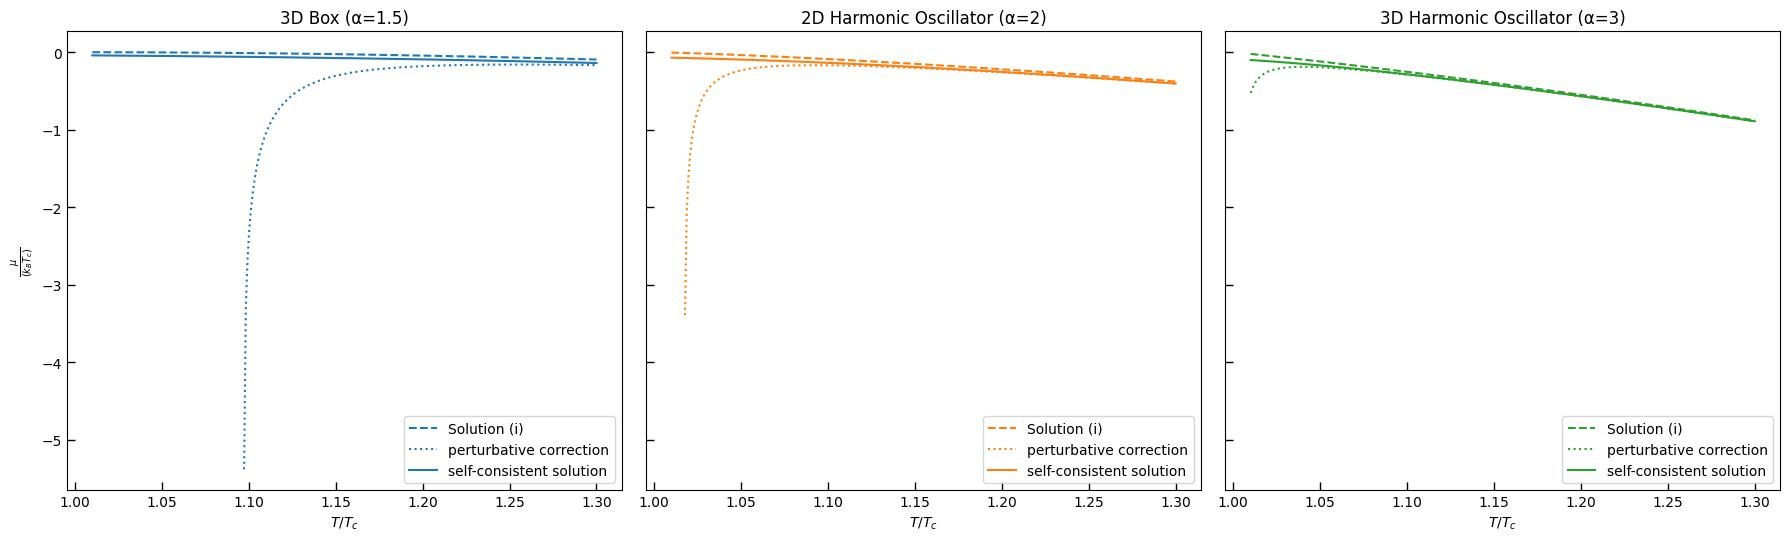

In [82]:
import numpy as np
import mpmath
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Set high precision for mpmath
mpmath.mp.dps = 25  # Decimal places of precision

# Constants
N = 100  # Total number of particles

# Temperature range above T_c
T_over_Tc = np.linspace(1.01, 1.30, 300)

# Potentials and their corresponding alpha values
potentials = {
    '3D Box (α=1.5)': 1.5,
    '2D Harmonic Oscillator (α=2)': 2.0,
    '3D Harmonic Oscillator (α=3)': 3.0
}

# Initialize dictionaries to store results
results = {
    'Solution (i)': {},
    'Solution (ii)': {},
    'Solution (iii)': {}
}

# Loop over potentials
for label, alpha in potentials.items():
    T_Tc_values = T_over_Tc.copy()
    zeta_alpha = float(mpmath.zeta(alpha))
    
    # Arrays to store results
    z_i = np.zeros_like(T_Tc_values)
    mu_over_kTc_i = np.zeros_like(T_Tc_values)
    
    z_ii = np.zeros_like(T_Tc_values)
    mu_over_kTc_ii = np.zeros_like(T_Tc_values)
    
    z_iii = np.zeros_like(T_Tc_values)
    mu_over_kTc_iii = np.zeros_like(T_Tc_values)
    
    # Solution (i)
    for i, T_Tc in enumerate(T_Tc_values):
        RHS = zeta_alpha * T_Tc ** (-alpha)
        
        # Function for Solution (i)
        def f_i(z):
            if z <= 0.0 or z >= 1.0:
                return np.inf
            return float(mpmath.polylog(alpha, z)) - RHS
        
        try:
            sol = root_scalar(f_i, bracket=[1e-12, 1 - 1e-12], method='brentq')
            if sol.converged:
                z_i[i] = sol.root
                mu_over_kTc_i[i] = T_Tc * np.log(z_i[i])
            else:
                z_i[i] = np.nan
                mu_over_kTc_i[i] = np.nan
        except Exception:
            z_i[i] = np.nan
            mu_over_kTc_i[i] = np.nan
    
    # Solution (ii)
    n0_z_i = z_i / (1 - z_i)
    N_minus_n0 = N - n0_z_i
    
    for i, T_Tc in enumerate(T_Tc_values):
        RHS = (N_minus_n0[i] * zeta_alpha) / (N * T_Tc ** alpha)
        
        # Function for Solution (ii)
        def f_ii(z):
            if z <= 0.0 or z >= 1.0:
                return np.inf
            return float(mpmath.polylog(alpha, z)) - RHS
        
        z_guess = z_i[i]
        if np.isnan(z_guess) or z_guess <= 0.0 or z_guess >= 1.0:
            z_guess = 0.5
        
        try:
            sol = root_scalar(f_ii, bracket=[1e-12, 1 - 1e-12], x0=z_guess, method='brentq')
            if sol.converged:
                z_ii[i] = sol.root
                mu_over_kTc_ii[i] = T_Tc * np.log(z_ii[i])
            else:
                z_ii[i] = np.nan
                mu_over_kTc_ii[i] = np.nan
        except Exception:
            z_ii[i] = np.nan
            mu_over_kTc_ii[i] = np.nan
    
    # Solution (iii)
    for i, T_Tc in enumerate(T_Tc_values):
        # Function for Solution (iii)
        def f_iii(z):
            if z <= 0.0 or z >= 1.0:
                return np.inf
            n0_val = z / (1 - z)
            polylog_val = float(mpmath.polylog(alpha, z))
            N_ex_val = N * T_Tc ** alpha * polylog_val / zeta_alpha
            return N - n0_val - N_ex_val
        
        z_guess = z_ii[i]
        if np.isnan(z_guess) or z_guess <= 0.0 or z_guess >= 1.0:
            z_guess = 0.5
        
        try:
            sol = root_scalar(f_iii, bracket=[1e-12, 1 - 1e-12], x0=z_guess, method='brentq')
            if sol.converged:
                z_iii[i] = sol.root
                mu_over_kTc_iii[i] = T_Tc * np.log(z_iii[i])
            else:
                z_iii[i] = np.nan
                mu_over_kTc_iii[i] = np.nan
        except Exception:
            z_iii[i] = np.nan
            mu_over_kTc_iii[i] = np.nan
    
    # Store results
    results['Solution (i)'][label] = {
        'T_Tc': T_Tc_values,
        'mu_over_kTc': mu_over_kTc_i,
        'z': z_i
    }
    results['Solution (ii)'][label] = {
        'T_Tc': T_Tc_values,
        'mu_over_kTc': mu_over_kTc_ii,
        'z': z_ii
    }
    results['Solution (iii)'][label] = {
        'T_Tc': T_Tc_values,
        'mu_over_kTc': mu_over_kTc_iii,
        'z': z_iii
    }

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Use default colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for ax, (label, alpha) in zip(axes, potentials.items()):
    # Extract data for plotting
    T_Tc = results['Solution (i)'][label]['T_Tc']
    mu_i = results['Solution (i)'][label]['mu_over_kTc']
    mu_ii = results['Solution (ii)'][label]['mu_over_kTc']
    mu_iii = results['Solution (iii)'][label]['mu_over_kTc']
    
    # Plot the solutions with the same color for each potential
    color = colors[list(potentials.keys()).index(label)]
    
    ax.plot(T_Tc, mu_i, label='Solution (i)', linestyle='--', color=color)
    ax.plot(T_Tc, mu_ii, label='perturbative correction', linestyle='dotted', color=color)
    ax.plot(T_Tc, mu_iii, label='self-consistent solution', linestyle='-', color=color)
    
    ax.set_title(f'{label}')
    ax.set_xlabel(r'$T/T_c$')
    ax.legend(loc='lower right')  # Legend in the bottom right
    ax.tick_params(axis='both', direction='in', length=6, width=1)

axes[0].set_ylabel(r'$\frac{\mu}{(k_B T_c)}$')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('question4.png')
plt.show()

### Exercise 5

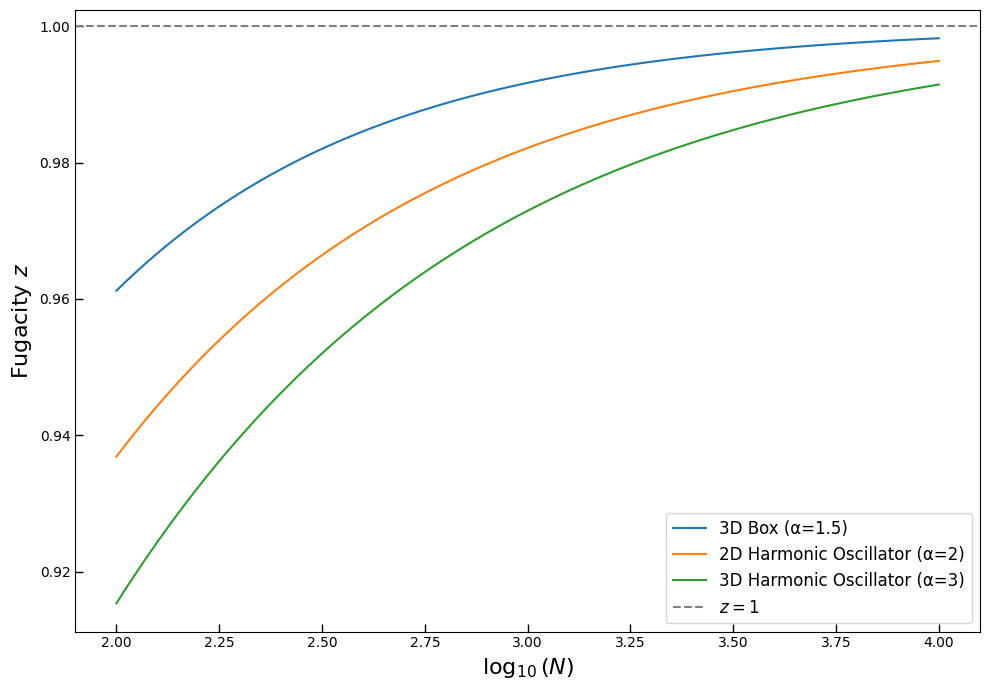

In [83]:
import numpy as np
import mpmath
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Set high precision for mpmath
mpmath.mp.dps = 25  # Decimal places of precision

# Potentials and their corresponding alpha values
potentials = {
    '3D Box (α=1.5)': 1.5,
    '2D Harmonic Oscillator (α=2)': 2.0,
    '3D Harmonic Oscillator (α=3)': 3.0
}

# Define N values from 1e2 to 1e4 on a logarithmic scale
N_values = np.logspace(2, 4, num=100)  # 100 points between 1e2 and 1e4
log_N_values = np.log10(N_values)  # For plotting

# Initialize dictionary to store results
z_results = {}

for label, alpha in potentials.items():
    zeta_alpha = float(mpmath.zeta(alpha))
    z_values = np.zeros_like(N_values)
    
    for i, N in enumerate(N_values):
        # Define the function to find root: N - n0(z) - N_ex(z) = 0
        def f(z):
            if z <= 0.0 or z >= 1.0:
                return np.inf
            n0_val = z / (1 - z)
            polylog_val = float(mpmath.polylog(alpha, z))
            N_ex_val = N * polylog_val / zeta_alpha
            return N - n0_val - N_ex_val
        
        # Initial guess: z close to 1 (since z approaches 1 as N increases)
        z_guess = 1 - 1e-5
        
        # Solve for z
        try:
            sol = root_scalar(f, bracket=[1e-12, 1 - 1e-12], x0=z_guess, method='brentq')
            if sol.converged:
                z_solution = sol.root
                z_values[i] = z_solution
            else:
                z_values[i] = np.nan
        except Exception:
            z_values[i] = np.nan
    
    # Store results
    z_results[label] = z_values

# Plotting z vs. log10(N)
plt.figure(figsize=(10, 7))

for label in potentials.keys():
    z_values = z_results[label]
    plt.plot(log_N_values, z_values, label=label)

# Add a horizontal dotted line at z = 1
plt.axhline(y=1, color='grey', linestyle='--', label=r'$z=1$')

plt.xlabel(r'$\log_{10}(N)$', fontsize=16)
plt.ylabel('Fugacity $z$', fontsize=16)
plt.legend(fontsize=12, loc = 'lower right')
plt.tick_params(axis='both', direction='in', length=6, width=1)
plt.tight_layout()
plt.savefig('question5.png')
plt.show()

### Exercise 6

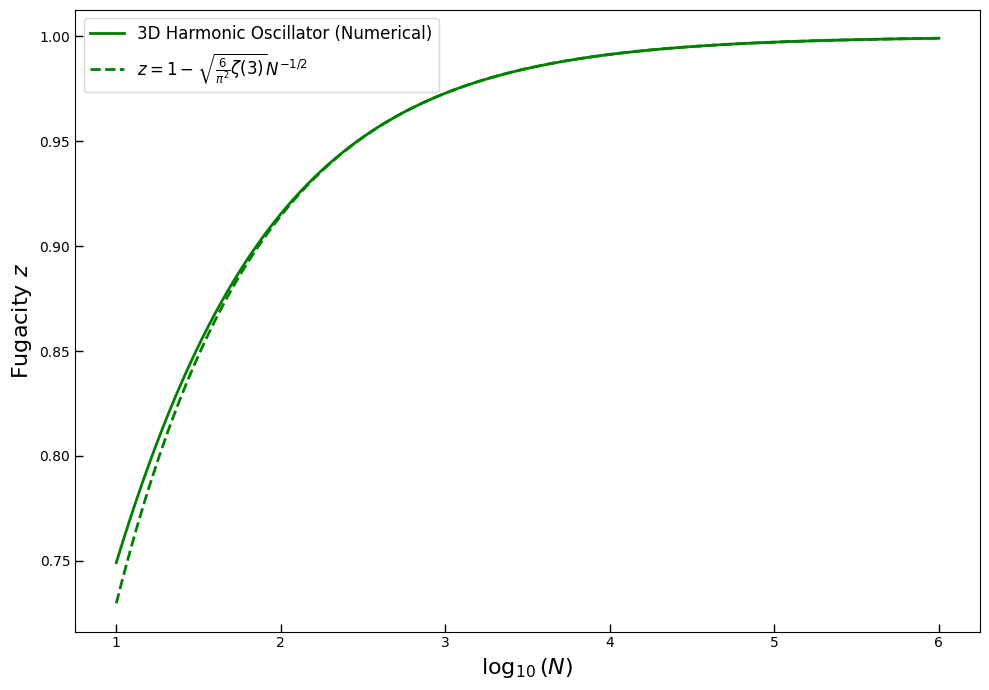

In [87]:
import numpy as np
import mpmath
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

# Set high precision for mpmath
mpmath.mp.dps = 25  # Decimal places of precision

# Only use the 3D Harmonic Oscillator (α=3)
alpha = 3.0

# Define N values from 10 to 1e6 on a logarithmic scale
N_values = np.logspace(1, 6, num=1000)  # 1000 points between 10 and 1e6 for better resolution
log_N_values = np.log10(N_values)  # For plotting

# Initialize z values
zeta_alpha = float(mpmath.zeta(alpha))
z_values = np.zeros_like(N_values)

# Compute z numerically
for i, N in enumerate(N_values):
    # Define the function to find root: N - n0(z) - N_ex(z) = 0
    def f(z):
        if z <= 0.0 or z >= 1.0:
            return np.inf
        n0_val = z / (1 - z)
        polylog_val = float(mpmath.polylog(alpha, z))
        N_ex_val = N * polylog_val / zeta_alpha
        return N - n0_val - N_ex_val
    
    # Initial guess: z close to 1 (since z approaches 1 as N increases)
    z_guess = 1 - 1e-5
    
    # Solve for z
    try:
        sol = root_scalar(f, bracket=[1e-12, 1 - 1e-12], x0=z_guess, method='brentq')
        if sol.converged:
            z_solution = sol.root
            z_values[i] = z_solution
        else:
            z_values[i] = np.nan
    except Exception:
        z_values[i] = np.nan

# Compute the approximation z = 1 - sqrt(6 / (pi^2) * zeta(3)) * N^{-1/2}
z_approx3 = 1 - np.sqrt(6 / (np.pi**2) * mpmath.zeta(3)) * N_values**(-1/2)

# Plotting z vs. log10(N) for the 3D Harmonic Oscillator (α=3)
plt.figure(figsize=(10, 7))

# Plot the numerical solution
plt.plot(log_N_values, z_values, label='3D Harmonic Oscillator (Numerical)', linewidth=2, color='green')

# Plot the approximation
plt.plot(log_N_values, z_approx3, 'g--', label=r'$z = 1 - \sqrt{\frac{6}{\pi^2} \zeta(3)} N^{-1/2}$', linewidth=2)

plt.xlabel(r'$\log_{10}(N)$', fontsize=16)
plt.ylabel('Fugacity $z$', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(axis='both', direction='in', length=6, width=1)
plt.tight_layout()
plt.savefig('question6.png')
plt.show()
